<h1> Project 2 Handwritten Character Recognition </h1>
<h4>Aim: The aim of this project is to automatically convert handwritten text into machine encoded text.</h4>


<p><a href="#section-1">1. Read the parser.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model</a></p>
<p><a href="#section-2">2. Images can be of different shape thus resize all your images to have the same shape (for example = (128,32))  </a></p>
<p><a href="#section-3">3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1</a></p>
<p><a href="#section-4">4. Create a list of all characters and use the character’s index to encode the actual words into digits</a></p>
<p><a href="#section-5">5. Pad all the words to have a similar length</a></p>
<p><a href="#section-6">6. Split your dataset for training and testing   </a></p>
<p><a href="#section-7">7. Create a model for training:   
    <ol type="a">
     <li> Add several CNN layers to extract the sequence of features </li>
     <li> Add Bi-LSTM layers to propagate through the sequence </li>
     <li> Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax.</li>
    </ol>
  </a></p>
<p><a href="#section-8">8. The output sequence from the output layer will be fed to the CTC layer.  </a></p>
<p><a href="#section-9">9. Predict output using your model (do not use the last loss layer) on validation images, use ctc_decode to decode your output and then print the actual words using the indexes from your character’s list. </a></p>

## Libraries and dataset

**Required libraries**
```
gdown
matplotlib
opencv-python
numpy
pandas
scikit-learn
tensorflow
```
**Dataset**

`IAM Dataset` [https://drive.google.com/file/d/1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad/view?usp=share_link
](https://drive.google.com/file/d/1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad/view?usp=share_link
)

`parser.txt` [https://drive.google.com/file/d/1Y6t8oVCiBOl7PeC-n9mKLb3Lr1AEvAtt/view?usp=share_link
](https://drive.google.com/file/d/1Y6t8oVCiBOl7PeC-n9mKLb3Lr1AEvAtt/view?usp=share_link
)

**Uncomment the below cell to download the required libraries**

In [ ]:
# !pip install --upgrade --no-cache gdown
# !pip install -U scikit-learn
# !pip install matplotlib
# !pip install numpy
# !pip install opencv-python
# !pip install pandas
# !pip install tensorflow

In [ ]:
# https://drive.google.com/file/d/1Y6t8oVCiBOl7PeC-n9mKLb3Lr1AEvAtt/view?usp=share_link
!gdown 1Y6t8oVCiBOl7PeC-n9mKLb3Lr1AEvAtt

Downloading...
From: https://drive.google.com/uc?id=1Y6t8oVCiBOl7PeC-n9mKLb3Lr1AEvAtt
To: /content/parser.txt
100% 5.30M/5.30M [00:00<00:00, 21.7MB/s]


In [ ]:
# https://drive.google.com/file/d/1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad/view?usp=share_link
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad" -O words.tgz && rm -rf /tmp/cookies.txt

--2023-03-10 01:13:16--  https://docs.google.com/uc?export=download&confirm=&id=1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad
Resolving docs.google.com (docs.google.com)... 172.217.194.139, 172.217.194.113, 172.217.194.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vl98bp58d2unakutgopo3l85o8j8ened/1678410750000/12486552344848071275/*/1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad?e=download&uuid=2b66de5f-2573-4f8c-9e14-d5342de2114f [following]
--2023-03-10 01:13:17--  https://doc-00-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vl98bp58d2unakutgopo3l85o8j8ened/1678410750000/12486552344848071275/*/1Br0vXBTcwZwlxOpPFPxsYIAiIAdUcEad?e=download&uuid=2b66de5f-2573-4f8c-9e14-d5342de2114f
Resolving doc-00-ao-docs.googleusercontent.com (doc-00-ao-docs.googleusercontent.com)... 74.125.24.132

In [ ]:
!mkdir words
!tar -xvzf words.tgz -C words

In [ ]:
!ls

parser.txt  sample_data  words	words.tgz


## Import libraries

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, \
                                    PReLU, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow. keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

K.set_image_data_format('channels_last')
K.image_data_format()

'channels_last'

In [ ]:
# define constants
R_C = 10000
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
max_label_len = 0
batch_size = 32
epochs = 40
e = str(epochs)
height = 32
width = 128

In [ ]:
# initialize lists
train_images, train_labels, train_input_length, train_label_length, train_original_text = [], [], [], [], []
valid_images, valid_labels, valid_input_length, valid_label_length, valid_original_text = [], [], [], [], []

## <h2 id="section-1">1. Read the <code>parser.txt</code> file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model </h2>


In [ ]:
# read and process data
with open('parser.txt') as f:
    contents = f.readlines()[:R_C]

contents = [line.strip() for line in contents]

## <h2 id="section-2"> 2. Images can be of different shape thus resize all your images to have the same shape (for example = (128,32)) </h2>     

1. Resizes the image to have a height of 32 pixels while preserving the aspect
ratio. The width is adjusted to maintain the aspect ratio.
1. Adds padding to the top and/or right of the image if necessary to make the width 128 pixels.
1. Resizes the image to a fixed size of 32x128 pixels.
1. Inverts the colors of the image (i.e., white becomes black and black becomes white).
1. Normalizes the pixel values of the image to be between 0 and 1.
1. Adds a channel dimension to the image (i.e., the resulting shape is (32, 128, 1)).
.

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    # Resize image while preserving aspect ratio
    new_w, new_h = 32, int(32 * img.shape[1] / img.shape[0])
    img = cv2.resize(img, (new_h, new_w))

    # Add padding if necessary
    pad_w, pad_h = max(0, 32 - img.shape[0]), max(0, 128 - img.shape[1])
    img = cv2.copyMakeBorder(img, 0, pad_w, 0, pad_h, cv2.BORDER_CONSTANT, value=255)

    # Resize again if necessary
    img = cv2.resize(img, (128, 32))

    # Invert colors and normalize
    img =  normalize(img)

    # Add channel dimension
    img = np.expand_dims(img, axis=-1)

    return img

## <h2 id="section-3"> 3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1 </h2>

In [ ]:
def normalize(img):
    img = 1 - img / 255.0
    return img

## <h2 id="section-5"> 4. Create a list of all characters and use the character’s index to encode the actual words into digits </h2>

This function takes a text input txt as a string and encodes each character in the string into a numerical label using a predefined character list `char_list`. Here's what each line of the function does:

`return [char_list.index(chara) for chara in txt]`: This is a list comprehension that loops over each character chara in the txt input and looks up its index in the `char_list` using the `index()` method. The resulting list of indices is then returned.

In [ ]:
def encode_to_labels(txt):
    # encoding each output word into digits
    return [char_list.index(chara) for chara in txt]

In [ ]:
for index, line in enumerate(contents):
    splits = line.split(' ')
    if len(splits) < 9:
        # Skip the line if it does not have a valid format
        continue
    status = splits[1]

    if status == 'ok':
        word_id, word = splits[0], "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = f'words/{splits_id[0]}/{splits_id[0]}-{splits_id[1]}/{word_id}.png'

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
#             print(word)
            label = encode_to_labels(word)
        except:
            continue

        # split data into train and validation sets
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        # update max label length
        if len(word) > max_label_len:
            max_label_len = len(word)

## <h2 id="section-5"> 5. Pad all the words to have a similar length </h2>

1. `pad_sequences` is a function from the keras.preprocessing.sequence module. It takes a list of sequences (in this case, `train_labels`), and pads/truncates them to a specified length.
2. `train_labels` is a list of integer label sequences, where each integer corresponds to a character in a string. For example, if the string was "hello", the integer sequence might be `[8, 5, 12, 12, 15]`, where 8 corresponds to "h", 5 corresponds to "e", and so on.
3. `max_label_len` is an integer that specifies the maximum length to which each sequence should be padded or truncated. This is necessary because the neural network model requires inputs of a fixed length.
4. `padding='post'` specifies that padding should be added to the end of each sequence (i.e., after the sequence of integers representing the characters).
5. `value=len(char_list`) specifies the value to use for padding. `char_list` is a list of unique characters that appear in the training data, and len(char_list) is used as the padding value because it is one more than the largest integer in `char_list` (since the integers used to represent characters start at 0). Therefore, the padding value will not overlap with any of the actual characters in the data.

In [ ]:
# pad sequences
train_pad_label = pad_sequences(train_labels,
                                maxlen=max_label_len,
                                padding='post',
                                value=len(char_list))
val_pad_label = pad_sequences(valid_labels,
                              maxlen=max_label_len,
                              padding='post',
                              value=len(char_list))

## <h2 id="section-6"> 6. Split your dataset for training and testing </h2>   

In [ ]:
# convert data to numpy arrays
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [ ]:
train_pad_label[3101]

array([70, 67, 56, 65, 55, 60, 65, 58, 78, 78, 78, 78, 78, 78, 78, 78],
      dtype=int32)

In [ ]:
train_pad_label.shape, val_pad_label.shape

((7850, 16), (875, 16))

## <h2 id="section-7">7. Create a model for training:     </h2>                                                                                   
<ol type="a">
<li> Add several CNN layers to extract the sequence of features </li>
     
<li> Add Bi-LSTM layers to propagate through the sequence </li>
     
<li>  Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax. </li>
</ol>



1. Create the input layer by typing `inputs = Input(shape=(height, width,1))`. This layer will receive the input data, which is a 2D matrix with one channel of size `height` x `width` (i.e., grayscale image).

2. Establish the convolutional layers: `conv_1=Conv2D(32, (3,3), padding='same')(inputs)`. To extract features, these layers apply a set of filters to the incoming data. We have four convolutional layers with an increasing number of filters, a 3x3 kernel size, and the same padding.

3. Write the activation function as `conv_1 = PReLU(alpha initializer=tf.keras.initializers.Constant(value=0.25))(conv_1)`. The output of the convolutional layers is activated using a non-linear activation function in this layer. To avoid the dying ReLU issue, we utilise a Parametric Rectified Linear Unit (PReLU) with a tiny negative slope.

4. Insert a Dropout layer: `conv_1 = tf.keras.layers.Dropout(rate=0.2)(conv_1)`. To avoid overfitting, this layer randomly removes a portion of the input units.

5. Establish the pooling layers: `pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)` is a formula. These layers take the maximum value in a pooling area to downsample the output of the convolutional layers. We employ two pooling layers with kernel sizes of 2x2 in this case.

6. Steps 2–5 should be repeated for the following three convolutional blocks, increasing the number of filters and reducing the spatial dimensions.

7. Define the squeeze layer as follows:`squeezed = Lambda(lambda x: K.squeeze(x, 1))(batch_norm 6)`. This layer compresses the output of the previous convolutional layer, removing spatial dimensions and converting it to a series of feature vectors. This is required to feed the output to the next LSTM layers.

8. Create the bidirectional LSTM layer using the following formula: `blstm_2 = Bi LSTM layers(nunits=128, squeezed=squeezed, dropout rate=0.2)`. This layer employs a bidirectional LSTM, which analyses the input sequence in both directions and captures long-term dependencies. To avoid overfitting, we utilise a two-layer LSTM with 128 units and a dropout rate of 0.2.

9. Establish the output layer: `outputs = Dense(len(char_list)+1, activation ='softmax')(blstm_2)`. This layer converts the LSTM layers' output into class probabilities. We utilise a dense layer with a softmax activation function to generate a probability distribution across the classes in this case.

10. Create the model by typing `nn_model = Model(inputs, outputs)`. This layer specifies the whole model, which accepts input and provides output.

11. Enter the model's name: `nn_model.name = 'BiLSTM"`. This is optional, however it may help with identification and troubleshooting.

Return the model, output layer, and input layer as follows:`return nn_model, outputs, inputs`.

In [ ]:
def BiLSTM_Model():
    # input with shape of height=32 and width=128
    inputs = Input(shape=(height, width ,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(32, (3,3), padding='same')(inputs)
    conv_1 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_1)
    conv_1 = tf.keras.layers.Dropout(rate=0.2)(conv_1)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(64, (3,3), padding='same')(pool_1)
    conv_2 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_2)
    conv_2 = tf.keras.layers.Dropout(rate=0.2)(conv_2)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), padding='same')(pool_2)
    conv_3 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_3)
    conv_3 = tf.keras.layers.Dropout(rate=0.2)(conv_3)

    conv_4 = Conv2D(256, (3,3), padding='same')(conv_3)
    conv_4 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_4)
    conv_4 = tf.keras.layers.Dropout(rate=0.2)(conv_4)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(256, (3,3), padding='same')(pool_4)
    conv_5 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_5)
    conv_5 = tf.keras.layers.Dropout(rate=0.2)(conv_5)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    pool_5 = MaxPool2D(pool_size=(2, 1))(batch_norm_5)

    conv_6 = Conv2D(512, (2,2),)(pool_5)
    conv_6 = PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(conv_6)
    conv_6 = tf.keras.layers.Dropout(rate=0.2)(conv_6)
    batch_norm_6 = BatchNormalization()(conv_6)


    squeezed = Lambda(lambda x: K.squeeze(x, 1))(batch_norm_6)

    # bidirectional LSTM layers with units=128
    blstm_2 = Bi_LSTM_layers(nunits=128, squeezed=squeezed, dropout_rate=0.2)

    # number of classes will be the number of characters.
    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    nn_model = Model(inputs, outputs)
    nn_model._name = 'BiLSTM'
    return nn_model, outputs, inputs

<h3 id="section-nan">Bi-LSTM layers to learn the sequential data in the image</h3>
    Add several Bi-directional LSTM layers, whose input will be the extracted features from the CNN layers, to learn the sequential pattern from the images. You can add dropout layers for regularization. Finally, add the output layer to the model, where the number of classes will be the number of characters.


In [ ]:
def Bi_LSTM_layers(nunits, squeezed, dropout_rate=0.2):
    blstm_1 = Bidirectional(LSTM(nunits, return_sequences=True, dropout = dropout_rate))(squeezed)
    blstm_2 = Bidirectional(LSTM(nunits, return_sequences=True, dropout = dropout_rate))(blstm_1)
    return blstm_2

In [ ]:
nn_model, outputs, inputs = BiLSTM_Model()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 32)       320       
                                                                 
 p_re_lu (PReLU)             (None, 32, 128, 32)       131072    
                                                                 
 dropout (Dropout)           (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        18496     
                                                            

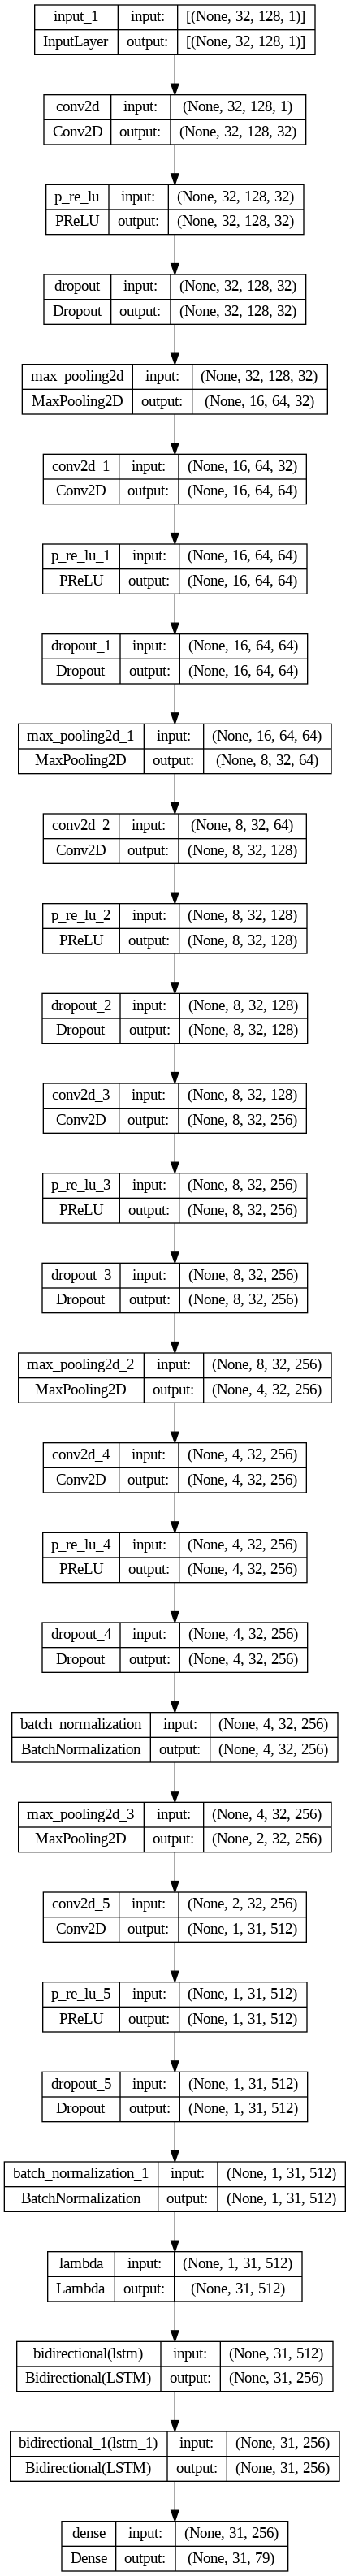

In [ ]:
nn_model.summary()
tf.keras.utils.plot_model(
    nn_model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
)

## <h2 id="section-8"> 8. The output sequence from the output layer will be fed to the CTC layer.  </h2>

In [ ]:
all_labels = Input(name='all_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_output = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, all_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, all_labels, input_length, label_length], outputs=loss_output)
model._name = 'BiLSTM_CTC'

Model: "BiLSTM_CTC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 32)  320         ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 128, 32)  131072      ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 32, 128, 32)  0           ['p_re_lu[0][0]']       

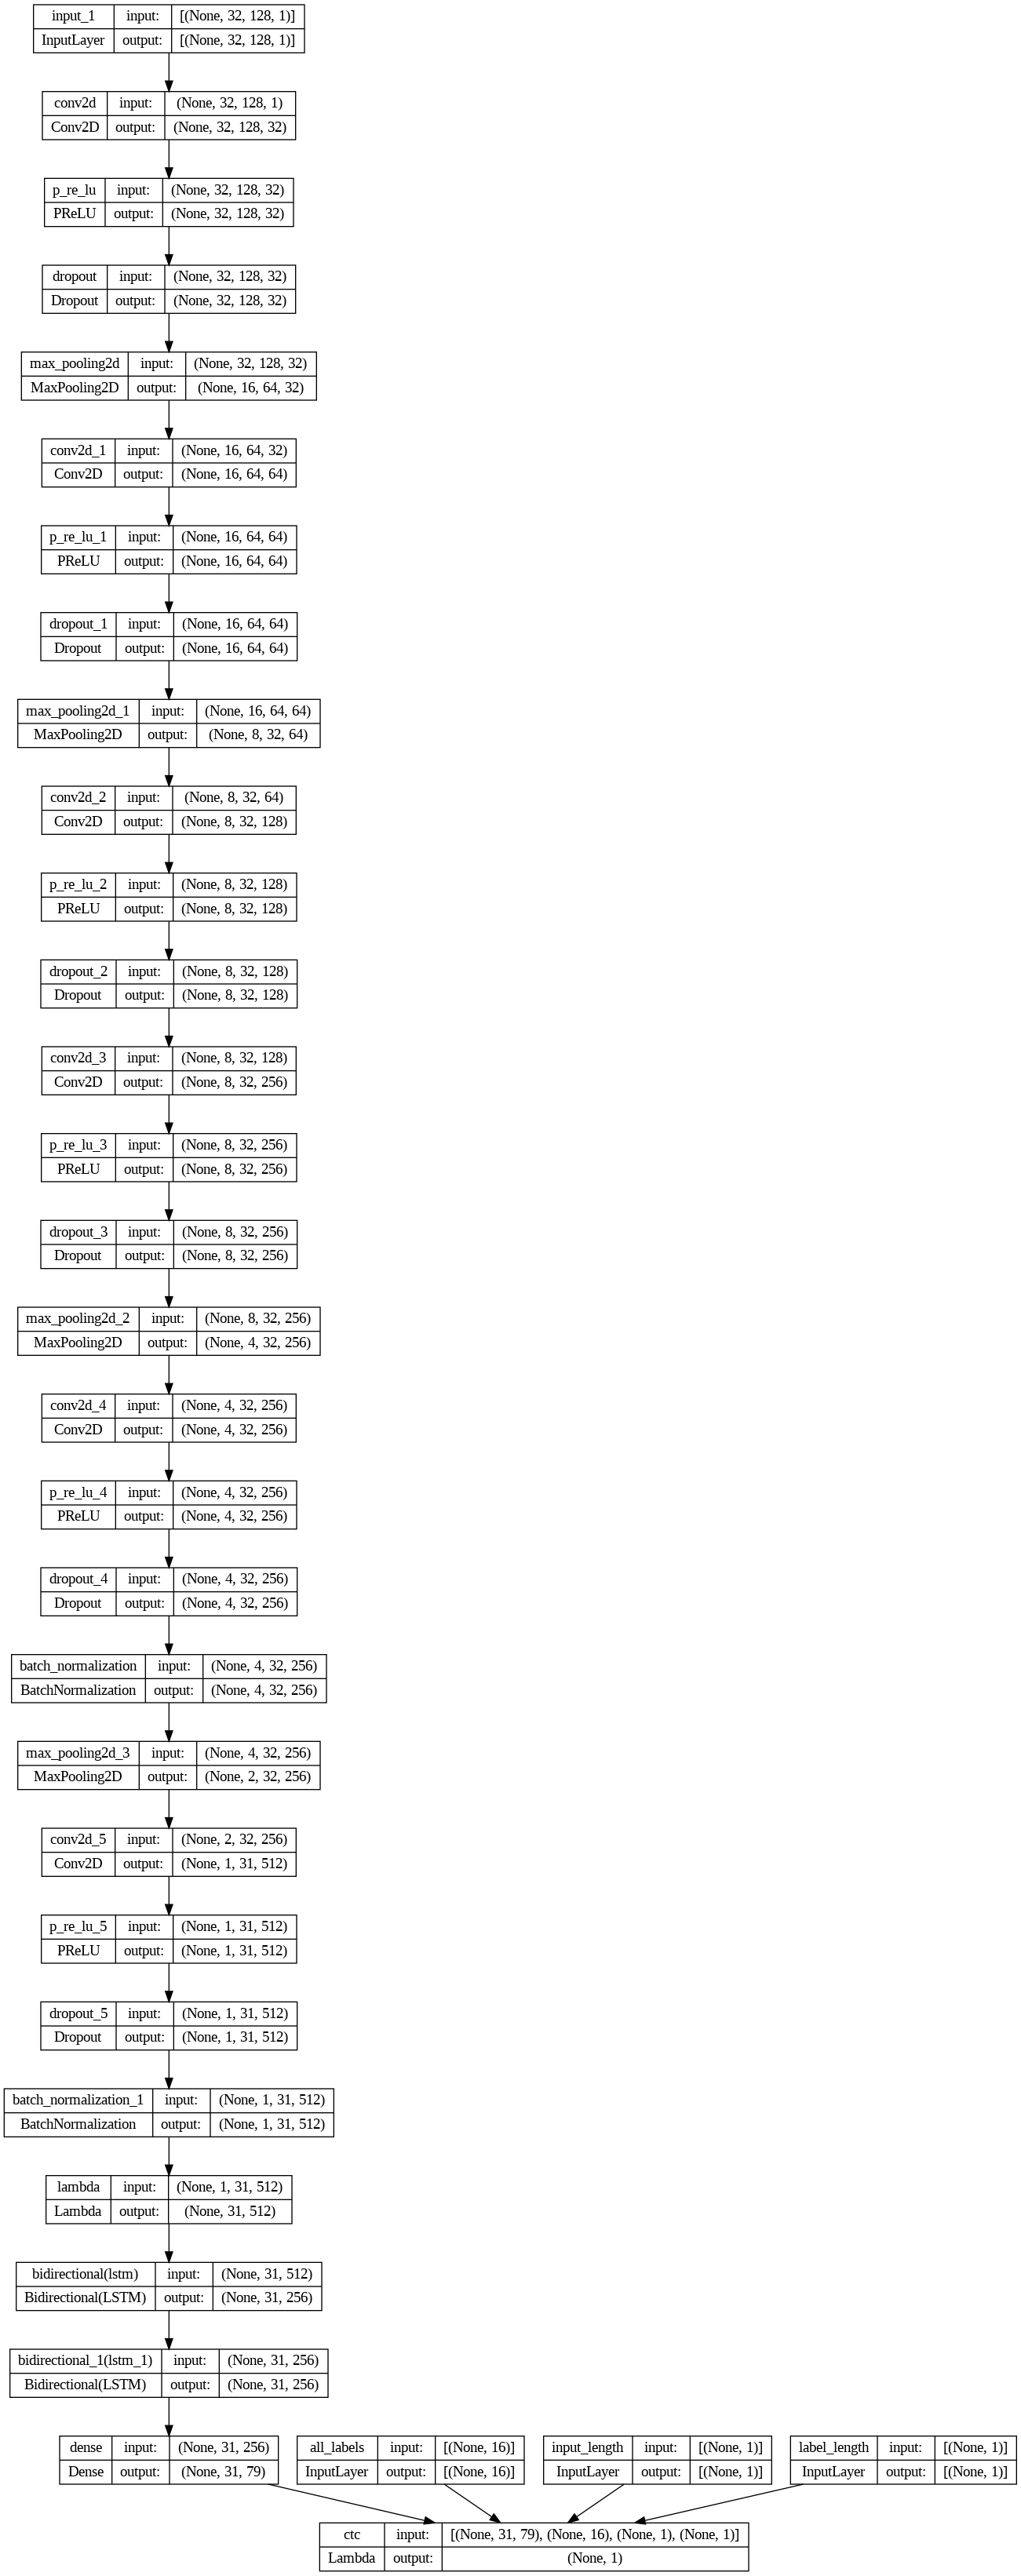

In [ ]:
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
filepath=f"Adam-o-{R_C}r-{epochs}e-{train_images.shape[0]}t-{valid_images.shape[0]}v.hdf5"

In [ ]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-7)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt, metrics=['accuracy',],run_eagerly=True)

In [ ]:
history = model.fit(x=[train_images, train_pad_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, val_pad_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/40


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


246/246 [==============================] - ETA: 0s - loss: 18.6631 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to Adam-o-10000r-40e-7850t-875v.hdf5
246/246 [==============================] - 42s 69ms/step - loss: 18.6631 - accuracy: 0.0000e+00 - val_loss: 22.3198 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/40
245/246 [============================>.] - ETA: 0s - loss: 13.9326 - accuracy: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00000
246/246 [==============================] - 11s 47ms/step - loss: 13.9287 - accuracy: 0.0000e+00 - val_loss: 21.7707 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/40
245/246 [============================>.] - ETA: 0s - loss: 12.2602 - accuracy: 0.0325
Epoch 3: val_accuracy improved from 0.00000 to 0.04343, saving model to Adam-o-10000r-40e-7850t-875v.hdf5
246/246 [==============================] - 12s 48ms/step - loss: 12.2628 - accuracy: 0.0325 - val_loss: 14.0477 - val_accuracy: 0.04

In [ ]:
model.save(filepath='./model.h5', overwrite=True, include_optimizer=True)

## <h2 id="section-9"> 9. Predict output using your model (do not use the last loss layer) on validation images, use ctc_decode to decode your output and then print the actual words using the indexes from your character’s list. </h2>

1. `i=rand_int = np.random.randint(1, 1000)`: This line creates a random integer between 1 and 999 (inclusive) and stores it in the variable `i`.
2. `j=i+5`: This line changes the value of the variable `j` to `i+5`. This indicates we'll forecast results for 5 consecutive validation photos beginning with `valid_images[i]`.
3. `prediction = nn_model.predict(valid_images[i:j])`: This line uses the neural network model `nn_model` to forecast the outputs for the 5 validation images beginning with `valid_images[i]`.
4. `K.ctc_decode(prediction, input length=np.ones) (prediction.shape[0]) * greedy=True, prediction.shape[1]) [0][0]`: The CTC decoder is used to decode the predictions in this line. The `ctc decode` function accepts the prediction tensor as well as the length of the input sequences (in this example, `np.ones') (prediction.shape[0]) * prediction.shape[1]` to set the length of each sequence to the number of timesteps in the prediction tensor), and a flag indicating whether a greedy decoder should be used (`greedy=True`). `ctc decode` returns a tuple with two elements: a tensor of decoded sequences and a tensor of sequence lengths. `[0][0]` is used to get the decoded sequences tensor from the tuple.
5. `out = K.get_value(decoded)`: This line returns the decoded sequences tensor value as a NumPy array. Since we need to iterate over the decoded sequences in the following step, we use `K.get_value` to transform the tensor to a NumPy array.
6. `for _, x in enumerate(out):`: This line begins a loop that loops over the decoded sequences.
`print("original_text = ", valid_original text[i])`: This line publishes the original text associated with the current validation image (i.e., `valid original_text[i]`).
`for p in x: if int(p)!= -1: print(char_list[int(p)], end = ")`: This line loops over the decoded sequence `x` and outputs the relevant characters using the `char_list` array. Since the `char_list` array links character indices to character strings, we first convert the index to an integer and then use `char_list[int(p)]` to acquire the appropriate character string. We only output characters with an index other than -1 since the CTC decoder interprets -1 as a blank character.
`plt.tight_layout`  `plt.axis('off') plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray, cmap=plt.cm.gray) plt.show()`: This line uses `plt.imshow` to display the current validation image (`valid_images[i]`) as a grayscale image. To eliminate padding and axes from the plot, use the `plt.tight_layout` and `plt.axis('off')` functions. Lastly, we display the plot using `plt.show`.
10. `i+=1`: This line increases I by one so that we may advance to the next validation picture in the following loop iteration.
11. `print('\n')`: This line produces a newline character to separate the validation picture output.

Finally, this code generates random indices for the validation images, predicts outputs for a sequence of 5 validation images using a trained neural network, decodes the predictions using a CTC decoder, and displays the predicted text along with the corresponding validation image for each of the 5 images. This procedure is performed for several sets of

i:488, j:493
1/1 [==============================] - 0s 24ms/step
original_text =   how
predicted text = hou

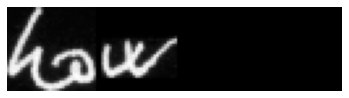



original_text =   Accra
predicted text = Aecre

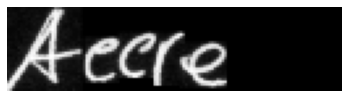



original_text =   ,
predicted text = ,

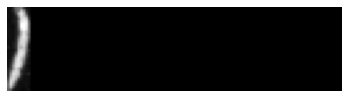



original_text =   demonstrators
predicted text = demonsteators

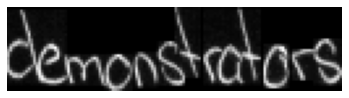



original_text =   If
predicted text = if

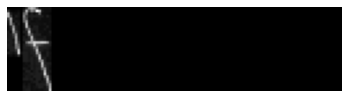

In [ ]:
# predict outputs on validation images
i=rand_int = np.random.randint(1, 1000)
j=i+5
print(f'i:{i}, j:{j}')
prediction = nn_model.predict(valid_images[i:j])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):

    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

In [ ]:
#plot accuracy and loss
def graph_plot(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc,)
    plt.plot(epochs, val_acc)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

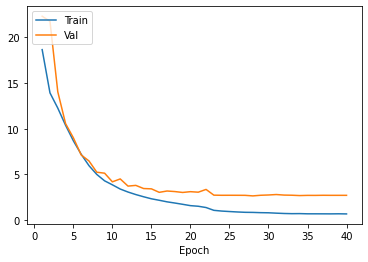

In [ ]:
graph_plot(epochs, loss, val_loss)

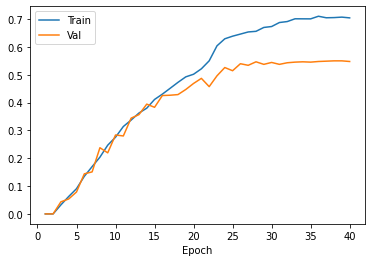

In [ ]:
graph_plot(epochs, acc, val_acc)

In [ ]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
print(f'Best loss : {best_loss}')
print(f'Best accuracy: {best_acc}')
print(f'Best validation accuracy: {best_val_acc}')

Best loss : 0.8387336134910583
Best accuracy: 0.6557961702346802
Best validation accuracy: 0.5462856888771057


## Conclusion

Initially, the parser.txt file containing image IDs and words is read, and the first 10000 occurrences are used for model training and testing. While images come in a variety of sizes, they are all downsized to the same form (for example, (128, 32)). The picture pixel values are normalised from 0 to 255 to a range of 0 to 1. Next, using the character's index, a list of all characters is generated, and the actual words are encoded into numbers. Padding is used to guarantee that all of the words have the same length. The dataset is then divided into training and testing sets. A training model is built by combining many CNN layers to extract the feature sequence, followed by Bi-LSTM layers to propagate across the sequence. A dense layer (output layer) is added, with a total number of neurons equal to the entire number of letters plus one, and softmax activation. The CTC layer receives the output sequence from the output layer. Lastly, using the character's list indexes, the model is used to predict outputs on validation pictures, CTC decode the result, and display the real words.